# GPU computation & batching for speed
The objective of this notebook is to teach you to make training faster from a computational perspective.

1) We will use a GPU to accelerate our computation.

2) We will batch our computation in the sense that the network will process multiple samples **at once**.

Your task: modify the test code to also run in batches on the GPU.

This will allow us to try larger networks :) - play with it.  See what accuracy you can get.

In [3]:
require 'cutorch'
require 'nn'
require 'cunn'
require 'optim'
print('ready')

ready	


In [2]:
cutorch.setDevice(1)

In [3]:
x = torch.randn(10,2)
print(x)

 1.2408  1.0470
 0.7939  0.5975
 0.3365 -0.6204
-2.7366  1.8571
-0.3617  2.1894
 2.5983 -1.1267
 0.1394  0.2652
-0.5232 -1.6361
 1.7156  0.1754
-0.7697 -0.2960
[torch.DoubleTensor of size 10x2]



In [4]:
xc = x:cuda()
print(xc)

 1.2408  1.0470
 0.7939  0.5975
 0.3365 -0.6204
-2.7366  1.8571
-0.3617  2.1894
 2.5983 -1.1267
 0.1394  0.2652
-0.5232 -1.6361
 1.7156  0.1754
-0.7697 -0.2960
[torch.CudaTensor of size 10x2]



In [5]:
-- you cannot operate on vectors living in different memory
-- the errors given are counterintuitive
print(x+xc)

bad argument #2 to '?' (number expected, got userdata)
stack traceback:
	[C]: at 0x7f577501af90
	[C]: in function '__add'
	[string "local f = function() return -- you cannot ope..."]:3: in function 'f'
	[string "local f = function() return -- you cannot ope..."]:3: in main chunk
	[C]: in function 'xpcall'
	/usr/local/share/torch/share/lua/5.1/itorch/main.lua:179: in function </usr/local/share/torch/share/lua/5.1/itorch/main.lua:143>
	/usr/local/share/torch/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/usr/local/share/torch/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/usr/local/share/torch/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/usr/local/share/torch/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/usr/local/share/torch/share/lua/5.1/itorch/main.lua:350: in main chunk
	[C]: in function 'require'
	[string "arg={'/home_lustre/dd-15-28-13/.local/share/j..."]:1: in main chunk: 

In [6]:
-- if we create another variable on the GPU, we can happily operate on those
yc = torch.randn(10,2):cuda()
print(torch.mm(yc:t(),xc))

 3.8116 -1.9104
 0.2679  2.9092
[torch.CudaTensor of size 2x2]



In [1]:
-- this should be familiar - we load up the data

-- snippet shamelessly ripped from https://github.com/torch/tutorials/blob/master/A_datasets/mnist.lua 
-- load the training data (downloads when first used)
tar = 'http://torch7.s3-website-us-east-1.amazonaws.com/data/mnist.t7.tgz'

if not paths.dirp('mnist.t7') then
   print('==> downloading dataset')
   os.execute('wget ' .. tar)
   os.execute('tar xvf ' .. paths.basename(tar))
end

train_file = 'mnist.t7/train_32x32.t7'
test_file = 'mnist.t7/test_32x32.t7'

----------------------------------------------------------------------
print('==> loading dataset')

-- We load the dataset from disk, it's straightforward

train_data = torch.load(train_file,'ascii')
test_data = torch.load(test_file,'ascii')

==> loading dataset	


In [4]:
-- let's preprocess the data a bit, so they are between 0 and 1
-- NEW: and move them to the GPU
train_data.data = train_data.data:reshape(60000,1024):type('torch.DoubleTensor'):mul(1.0 / 256.0):cuda()
train_data.labels = train_data.labels:cuda()
test_data.data = test_data.data:reshape(10000,1024):type('torch.DoubleTensor'):mul(1.0 / 256.0):cuda()
test_data.labels = test_data.labels:cuda()

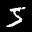

In [9]:
-- itorch.image will accept arrays living on the GPU
itorch.image(train_data.data[1]:reshape(32,32))

In [22]:
net = nn.Sequential()
net:add(nn.Linear(1024,700))
net:add(nn.PReLU())
net:add(nn.Linear(700,500))
net:add(nn.PReLU())
net:add(nn.Linear(500,300))
net:add(nn.PReLU())
net:add(nn.Linear(300,100))
net:add(nn.PReLU())
net:add(nn.Linear(100, 10))

-- move entire network to the GPU
net = net:cuda()

-- loss is cross-entropy (== logsoftmax + classnllcriterion)
loss = nn.CrossEntropyCriterion():cuda()
print(net)

parameters, gradParameters = net:getParameters()
print('*** Total number of parameters = ' .. parameters:nElement() .. ' ***')

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> output]
  (1): nn.Linear(1024 -> 700)
  (2): nn.PReLU
  (3): nn.Linear(700 -> 500)
  (4): nn.PReLU
  (5): nn.Linear(500 -> 300)
  (6): nn.PReLU
  (7): nn.Linear(300 -> 100)
  (8): nn.PReLU
  (9): nn.Linear(100 -> 10)
}
{
  gradInput : CudaTensor - empty
  modules : 
    {
      1 : 
        nn.Linear(1024 -> 700)
        {
          gradBias : CudaTensor - size: 700
          weight : CudaTensor - size: 700x1024
          bias : CudaTensor - size: 700
          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 700x1024
          output : CudaTensor - empty
        }
      2 : 
        nn.PReLU
        {
          weight : CudaTensor - size: 1
          nOutputPlane : 0
          output : CudaTensor - empty
          gradInput : CudaTensor - empty


          gradWeightBuf2 : CudaTensor - empty
          gradWeightBuf : CudaTensor - empty
          gradWeight : CudaTensor - size: 1
        }
      3 : 
        nn.Linear(700 -> 500)
        {
          gradBias : CudaTensor - size: 500
          weight : CudaTensor - size: 500x700
          bias : CudaTensor - size: 500
          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 500x700
          output : CudaTensor - empty
        }
      4 : 
        nn.PReLU
        {
          weight : CudaTensor - size: 1
          nOutputPlane : 0
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          gradWeightBuf2 : CudaTensor - empty
          gradWeightBuf : CudaTensor - empty
          gradWeight : CudaTensor - size: 1
        }
      5 : 
        nn.Linear(500 -> 300)
        {
          gradBias : CudaTensor - size: 300
          weight : CudaTensor - size: 300x500
          bias : CudaTensor - size: 300
          gradInput : Cud

          output : CudaTensor - empty
        }
      6 : 
        nn.PReLU
        {
          weight : CudaTensor - size: 1
          nOutputPlane : 0
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          gradWeightBuf2 : CudaTensor - empty
          gradWeightBuf : CudaTensor - empty
          gradWeight : CudaTensor - size: 1
        }
      7 : 
        nn.Linear(300 -> 100)
        {
          gradBias : CudaTensor - size: 100
          weight : CudaTensor - size: 100x300
          bias : CudaTensor - size: 100
          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 100x300
          output : CudaTensor - empty
        }
      8 : 
        nn.PReLU
        {
          weight : CudaTensor - size: 1
          nOutputPlane : 0
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          gradWeightBuf2 : CudaTensor - empty
   

       gradWeightBuf : CudaTensor - empty
          gradWeight : CudaTensor - size: 1
        }
      9 : 
        nn.Linear(100 -> 10)
        {
          gradBias : CudaTensor - size: 10
          weight : CudaTensor - size: 10x100
          bias : CudaTensor - size: 10
          gradInput : CudaTensor - empty
          gradWeight : CudaTensor - size: 10x100
          output : CudaTensor - empty
        }
    }
  output : CudaTensor - empty
}


*** Total number of parameters = 1249414 ***	


In [14]:
net = torch.load('mojeNN.dat'):cuda()

In [23]:
-- random initialization according to Xavier
local tmp = math.sqrt(1. / net:get(1).bias:size(1))
net:get(1).weight:uniform(-tmp, tmp)
net:get(1).bias:zero()
local tmp = math.sqrt(1. / net:get(3).bias:size(1))
net:get(3).weight:uniform(-tmp, tmp)
net:get(3).bias:zero()
local tmp = math.sqrt(1. / net:get(5).bias:size(1))
net:get(5).weight:uniform(-tmp, tmp)
net:get(5).bias:zero()
local tmp = math.sqrt(1. / net:get(7).bias:size(1))
net:get(7).weight:uniform(-tmp, tmp)
net:get(7).bias:zero()
local tmp = math.sqrt(1. / net:get(9).bias:size(1))
net:get(9).weight:uniform(-tmp, tmp)
net:get(9).bias:zero()

In [32]:
-- reset the state of the optimizer
opt_state = {}

In [46]:
execute_optimizer = optim.sgd
opt_config = {
    learningRate = 0.05,
    momentum = 0.6,
}

execute_optimizer = optim.adadelta
opt_config = {
   rho = 0.99,
   eps = 1e-8
}

-- execute_optimizer = optim.rmsprop
-- opt_config = {
--    learningRate = 0.01,
-- }

nepochs = 5
ntrain = 60000
ntest = 10000
batch_size = 60000
etest = 1
diagnostic_level = 1

-- train the network
for e=1,nepochs do
    
    local timer = torch.Timer() 
    local confmat = optim.ConfusionMatrix(10, {'0','1','2','3','4','5','6','7','8','9'})
    local train_err = 0
    local inputs = torch.Tensor(batch_size,32*32):cuda()
    local targets = torch.Tensor(batch_size):cuda()
    
    for b=1,ntrain/batch_size do
        
        function batch_eval(x)
            
            local err = 0
            
            if x ~= parameters then
                parameters:copy(x)
            end

            -- fill up the batch vector
            for i=1,batch_size do
                local ndx = (b-1) * batch_size + i
                inputs[i]:copy(train_data.data[ndx])
                targets[i] = train_data.labels[ndx]
            end
            
            gradParameters:zero()
            
            local ys = net:forward(inputs)
            local batch_err = loss:forward(ys, targets)
            local dt_dy = loss:backward(ys, targets)
            net:backward(inputs, dt_dy)
            
            -- add all results into the confusion matrix
            for i=1,batch_size do
                confmat:add(ys[i],targets[i])
            end
        
            train_err = train_err + batch_err
            return batch_err, gradParameters
        end
        
        execute_optimizer(batch_eval, parameters, opt_config, opt_state)
    end
    
    print('******************* EPOCH ' .. e .. ' ************************')

    print('TRAINING [error = ' .. train_err .. ']')
    if diagnostic_level > 0 then
        print(confmat:__tostring__())
    end
    
    -- compute testing error every etest epochs
    if e % etest == 0 then
        local terr = 0
        local misses = 0
        confmat:zero()
        for i=1,ntest do
            local x = test_data.data[i]
            local t = test_data.labels[i]
            local y = net:forward(x)
            confmat:add(y, t)
            local _, digit = torch.max(y,1)
            digit = digit[1]
            if digit ~= t then
                misses = misses + 1
            end
            terr = terr + loss:forward(y, t)
        end
        print('TESTING [error = ' .. terr .. '] misses = ' .. misses)
        if diagnostic_level > 0 then
            print(confmat:__tostring__())
        end
    end
        
    print('Epoch took ' .. timer:time().real .. ' seconds.')
end

******************* EPOCH 1 ************************	
TRAINING [error = 0.00024940184084699]	
ConfusionMatrix:
[[    5923       0       0       0       0       0       0       0       0       0]   100.000% 	[class: 0]
 [       0    6742       0       0       0       0       0       0       0       0]   100.000% 	[class: 1]
 [       0       0    5958       0       0       0       0       0       0       0]   100.000% 	[class: 2]
 [       0       0       0    6131       0       0       0       0       0       0]   100.000% 	[class: 3]
 [       0       0       0       0    5842       0       0       0       0       0]   100.000% 	[class: 4]
 [       0       0       0       0       0    5421       0       0       0       0]   100.000% 	[class: 5]
 [       0       0       0       0       0       0    5918       0       0       0]   100.000% 	[class: 6]
 [       0       0       0       0       0       0       0    6265       0       0]   100.000% 	[class: 7]
 [       0       0       0       

TESTING [error = 2006.8659954071] misses = 219	


ConfusionMatrix:
[[     965       1       1       2       1       2       4       0       2       2]   98.469% 	[class: 0]
 [       0    1126       1       2       1       0       1       0       4       0]   99.207% 	[class: 1]
 [       5       1    1004       6       2       0       3       5       6       0]   97.287% 	[class: 2]
 [       0       0       3     985       0       7       0       6       3       6]   97.525% 	[class: 3]
 [       1       0       2       0     961       0       4       3       0      11]   97.862% 	[class: 4]
 [       3       0       0       7       0     874       4       1       2       1]   97.982% 	[class: 5]
 [       5       3       2       0       5       8     932       0       3       0]   97.286% 	[class: 6]
 [       2       7       7       1       1       0       0    1004       3       3]   97.665% 	[class: 7]
 [       4       0       4       7       1       2       0       2     949       5]   97.433% 	[class: 8]
 [       2       3       0   

******************* EPOCH 2 ************************	
TRAINING [error = 0.00017538496467751]	


ConfusionMatrix:
[[    5923       0       0       0       0       0       0       0       0       0]   100.000% 	[class: 0]
 [       0    6742       0       0       0       0       0       0       0       0]   100.000% 	[class: 1]
 [       0       0    5958       0       0       0       0       0       0       0]   100.000% 	[class: 2]
 [       0       0       0    6131       0       0       0       0       0       0]   100.000% 	[class: 3]
 [       0       0       0       0    5842       0       0       0       0       0]   100.000% 	[class: 4]
 [       0       0       0       0       0    5421       0       0       0       0]   100.000% 	[class: 5]
 [       0       0       0       0       0       0    5918       0       0       0]   100.000% 	[class: 6]
 [       0       0       0       0       0       0       0    6265       0       0]   100.000% 	[class: 7]
 [       0       0       0       0       0       0       0       0    5851       0]   100.000% 	[class: 8]
 [       0       0  

TESTING [error = 2004.1554298401] misses = 219	


ConfusionMatrix:
[[     965       1       1       2       1       2       4       0       2       2]   98.469% 	[class: 0]
 [       0    1126       1       2       1       0       1       0       4       0]   99.207% 	[class: 1]
 [       4       1    1005       6       2       0       3       5       6       0]   97.384% 	[class: 2]
 [       0       0       3     986       0       6       0       6       3       6]   97.624% 	[class: 3]
 [       1       0       2       0     961       0       4       3       0      11]   97.862% 	[class: 4]
 [       3       0       0       7       0     873       4       1       3       1]   97.870% 	[class: 5]
 [       5       3       2       0       5       8     932       0       3       0]   97.286% 	[class: 6]
 [       2       7       8       1       1       0       0    1003       3       3]   97.568% 	[class: 7]
 [       4       0       4       7       1       1       1       2     949       5]   97.433% 	[class: 8]
 [       2       3       0   

******************* EPOCH 3 ************************	
TRAINING [error = 0.00015932458336465]	
ConfusionMatrix:
[[    5923       0       0       0       0       0       0       0       0       0]   100.000% 	[class: 0]
 [       0    6742       0       0       0       0       0       0       0       0]   100.000% 	[class: 1]
 [       0       0    5958       0       0       0       0       0       0       0]   100.000% 	[class: 2]
 [       0       0       0    6131       0       0       0       0       0       0]   100.000% 	[class: 3]
 [       0       0       0       0    5842       0       0       0       0       0]   100.000% 	[class: 4]
 [       0       0       0       0       0    5421       0       0       0       0]   100.000% 	[class: 5]
 [       0       0       0       0       0       0    5918       0       0       0]   100.000% 	[class: 6]
 [       0       0       0       0       0       0       0    6265       0       0]   100.000% 	[class: 7]
 [       0       0       0       

TESTING [error = 2004.5409355164] misses = 216	
ConfusionMatrix:
[[     965       1       1       2       1       2       4       0       2       2]   98.469% 	[class: 0]
 [       0    1126       1       2       1       0       1       0       4       0]   99.207% 	[class: 1]
 [       3       1    1006       6       2       0       3       5       6       0]   97.481% 	[class: 2]
 [       0       0       3     988       0       5       0       6       3       5]   97.822% 	[class: 3]
 [       1       0       2       0     961       0       4       3       0      11]   97.862% 	[class: 4]
 [       3       0       0       7       0     873       4       1       3       1]   97.870% 	[class: 5]
 [       5       3       2       0       5       8     932       0       3       0]   97.286% 	[class: 6]
 [       2       7       8       1       1       0       0    1003       3       3]   97.568% 	[class: 7]
 [       4       0       4       7       1       1       1       2     949       5]   9

******************* EPOCH 4 ************************	
TRAINING [error = 0.00015261919179466]	
ConfusionMatrix:
[[    5923       0       0       0       0       0       0       0       0       0]   100.000% 	[class: 0]
 [       0    6742       0       0       0       0       0       0       0       0]   100.000% 	[class: 1]
 [       0       0    5958       0       0       0       0       0       0       0]   100.000% 	[class: 2]
 [       0       0       0    6131       0       0       0       0       0       0]   100.000% 	[class: 3]
 [       0       0       0       0    5842       0       0       0       0       0]   100.000% 	[class: 4]
 [       0       0       0       0       0    5421       0       0       0       0]   100.000% 	[class: 5]
 [       0       0       0       0       0       0    5918       0       0       0]   100.000% 	[class: 6]
 [       0       0       0       0       0       0       0    6265       0       0]   100.000% 	[class: 7]
 [       0       0       0       

TESTING [error = 2006.1976108551] misses = 215	


ConfusionMatrix:
[[     965       1       1       2       1       2       4       0       2       2]   98.469% 	[class: 0]
 [       0    1126       1       2       1       0       1       0       4       0]   99.207% 	[class: 1]
 [       3       1    1006       6       2       0       3       5       6       0]   97.481% 	[class: 2]
 [       0       0       3     989       0       4       0       6       3       5]   97.921% 	[class: 3]
 [       1       0       2       0     962       0       4       3       0      10]   97.963% 	[class: 4]
 [       3       0       0       7       0     873       4       1       3       1]   97.870% 	[class: 5]
 [       5       3       2       0       5       8     932       0       3       0]   97.286% 	[class: 6]
 [       2       7       8       1       1       0       0    1003       3       3]   97.568% 	[class: 7]
 [       4       0       5       7       1       1       1       2     948       5]   97.331% 	[class: 8]
 [       2       3       0   

******************* EPOCH 5 ************************	
TRAINING [error = 0.00014900745009072]	
ConfusionMatrix:
[[    5923       0       0       0       0       0       0       0       0       0]   100.000% 	[class: 0]
 [       0    6742       0       0       0       0       0       0       0       0]   100.000% 	[class: 1]
 [       0       0    5958       0       0       0       0       0       0       0]   100.000% 	[class: 2]
 [       0       0       0    6131       0       0       0       0       0       0]   100.000% 	[class: 3]
 [       0       0       0       0    5842       0       0       0       0       0]   100.000% 	[class: 4]
 [       0       0       0       0       0    5421       0       0       0       0]   100.000% 	[class: 5]
 [       0       0       0       0       0       0    5918       0       0       0]   100.000% 	[class: 6]
 [       0       0       0       0       0       0       0    6265       0       0]   100.000% 	[class: 7]
 [       0       0       0       

TESTING [error = 2008.1472010612] misses = 217	


ConfusionMatrix:
[[     965       1       1       2       1       2       4       0       2       2]   98.469% 	[class: 0]
 [       0    1126       1       2       1       0       1       0       4       0]   99.207% 	[class: 1]
 [       3       1    1006       6       2       0       3       5       6       0]   97.481% 	[class: 2]
 [       0       0       3     989       0       4       0       6       3       5]   97.921% 	[class: 3]
 [       1       0       2       0     962       0       4       3       0      10]   97.963% 	[class: 4]
 [       3       0       0       7       0     872       4       1       4       1]   97.758% 	[class: 5]
 [       5       3       2       0       5       8     932       0       3       0]   97.286% 	[class: 6]
 [       2       7       8       1       1       0       0    1003       3       3]   97.568% 	[class: 7]
 [       4       0       5       7       1       1       1       2     948       5]   97.331% 	[class: 8]
 [       2       3       0   

Epoch took 8.3737559318542 seconds.	


In [21]:
torch.save('mojeNN.dat', net)